# Inter-Rater Agreement Analysis - EmpkinS Dataset

## Setup and Helper Functions

### Imports

In [1]:
import json
from pathlib import Path

import biopsykit as bp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fau_colors import cmaps, register_fausans_font

from pepbench.annotations import (
    compute_annotation_differences,
    load_annotations_from_dataset,
)
from pepbench.annotations.stats import bin_annotation_differences, compute_icc, describe_annotation_differences
from pepbench.datasets import EmpkinsDataset

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

[(0.3803921568627451, 0.49019607843137253, 0.6313725490196078),
 (0.7137254901960784, 0.7607843137254902, 0.807843137254902),
 (0.996078431372549, 0.807843137254902, 0.4627450980392157),
 (0.42745098039215684, 0.8156862745098039, 0.9647058823529412),
 (0.6745098039215687, 0.8235294117647058, 0.4588235294117647),
 (0.8666666666666667, 0.45098039215686275, 0.48627450980392156)]

In [3]:
root_path = Path("../../")

In [4]:
deploy_type = "local"

config_dict = json.load(root_path.joinpath("config.json").open(encoding="utf-8"))

empkins_base_path = Path(config_dict[deploy_type]["empkins_path"])
guardian_base_path = Path(config_dict[deploy_type]["guardian_path"])

In [5]:
paper_path = json.load(root_path.joinpath("paper_path.json").open(encoding="utf-8"))["paper_path"]
paper_path = Path(paper_path)

result_path = root_path.joinpath("results")
export_path = root_path.joinpath("exports")
img_path = export_path.joinpath("plots")
stats_path = export_path.joinpath("stats")

img_path_paper = paper_path.joinpath("img")
tab_path_paper = paper_path.joinpath("tab")
suppl_img_path_paper = paper_path.joinpath("supplementary_material/img")
suppl_tab_path_paper = paper_path.joinpath("supplementary_material/tab")

bp.utils.file_handling.mkdirs(
    [
        result_path,
        export_path,
        img_path,
        stats_path,
        img_path_paper,
        tab_path_paper,
        suppl_img_path_paper,
        suppl_tab_path_paper,
    ]
)

## EmpkinS Dataset

In [6]:
dataset_empkins_01 = EmpkinsDataset(empkins_base_path, label_type="rater_01")
dataset_empkins_01

,participant,condition,phase
0,VP_001,tsst,Prep
1,VP_001,tsst,Pause_1
2,VP_001,tsst,Talk
3,VP_001,tsst,Math
4,VP_001,tsst,Pause_5
...,...,...,...
145,VP_032,ftsst,Prep
146,VP_032,ftsst,Pause_1
147,VP_032,ftsst,Talk
148,VP_032,ftsst,Math


In [7]:
dataset_empkins_02 = EmpkinsDataset(empkins_base_path, label_type="rater_02")
dataset_empkins_02

,participant,condition,phase
0,VP_001,tsst,Prep
1,VP_001,tsst,Pause_1
2,VP_001,tsst,Talk
3,VP_001,tsst,Math
4,VP_001,tsst,Pause_5
...,...,...,...
145,VP_032,ftsst,Prep
146,VP_032,ftsst,Pause_1
147,VP_032,ftsst,Talk
148,VP_032,ftsst,Math


In [8]:
labels_total = load_annotations_from_dataset(dataset_empkins_01, dataset_empkins_02)

  0%|          | 0/150 [00:00<?, ?it/s]

In [9]:
labels_ecg_total = labels_total.xs("ECG", level="signal")
labels_icg_total = labels_total.xs("ICG", level="signal")

In [10]:
labels_ecg_diff = compute_annotation_differences(
    labels_ecg_total, sampling_rate_hz=dataset_empkins_01.sampling_rate_ecg
)
labels_icg_diff = compute_annotation_differences(
    labels_icg_total, sampling_rate_hz=dataset_empkins_01.sampling_rate_icg
)

labels_icg_diff.head()

difference_ms
participant condition phase heartbeat_id               
VP_001      tsst      Prep  0                     -15.0
                            1                      -1.0
                            2                      -4.0
                            3                      -4.0
                            4                      -1.0

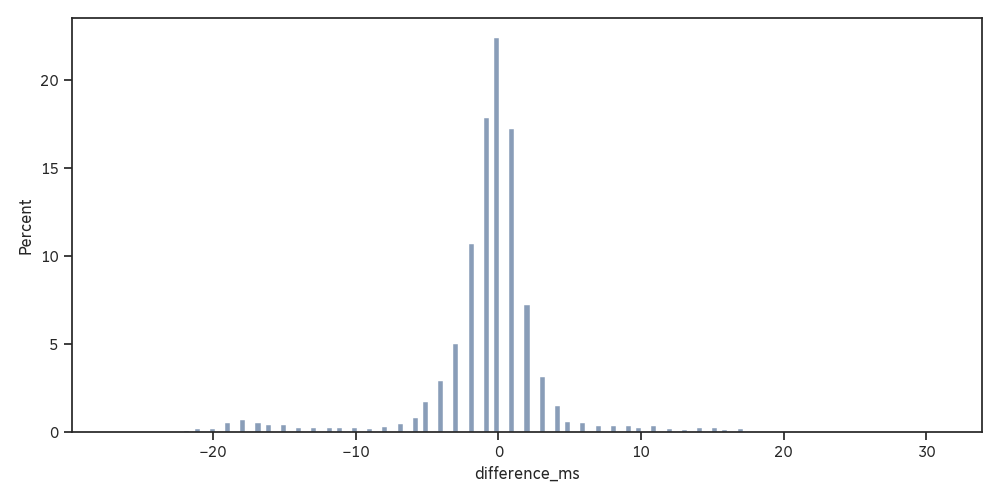

In [11]:
fig, ax = plt.subplots()

# label_counts_ecg = labels_ecg_diff.value_counts().sort_index().reset_index()
# label_counts_ecg = label_counts_ecg.assign(sample_difference=label_counts_ecg["sample_difference"].astype(int))

sns.histplot(data=labels_ecg_diff.reset_index(), x="difference_ms", ax=ax, stat="percent")
# sns.barplot(data=label_counts_ecg, x="sample_difference", y="count", ax=ax)

fig.tight_layout()

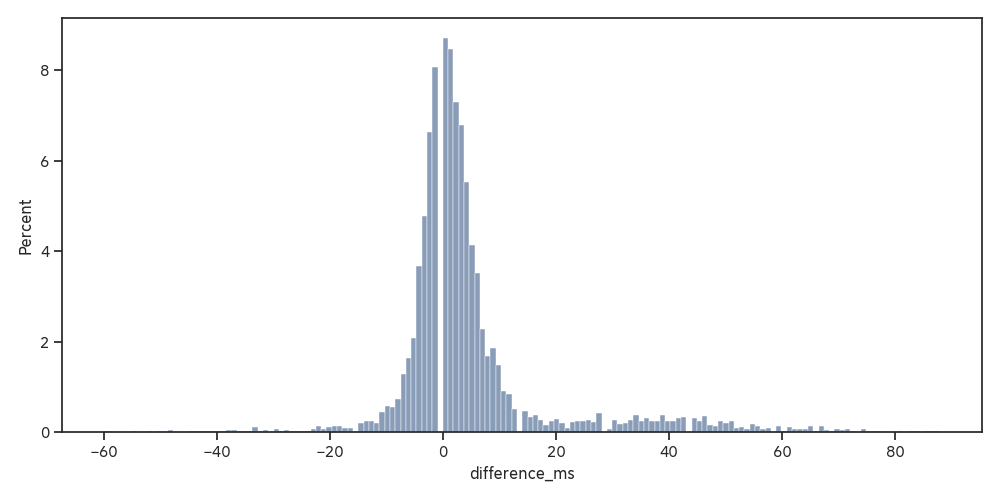

In [12]:
fig, ax = plt.subplots()

sns.histplot(data=labels_icg_diff, x="difference_ms", ax=ax, stat="percent")

fig.tight_layout()

In [13]:
labels_ecg_diff.abs()

difference_ms
participant condition phase   heartbeat_id               
VP_001      tsst      Prep    0                       1.0
                              1                       0.0
                              2                       1.0
                              3                       1.0
                              4                       2.0
...                                                   ...
VP_032      ftsst     Pause_5 7                       1.0
                              8                       1.0
                              9                       0.0
                              10                      2.0
                              11                      0.0

[5083 rows x 1 columns]

In [30]:
dict_results = {}

In [31]:
annotation_diff_ecg = describe_annotation_differences(labels_ecg_diff)
dict_results["ECG_Annotation_Difference"] = annotation_diff_ecg
annotation_diff_ecg

,count,mean,std,min,25%,50%,75%,max
difference_ms,4758.0,-0.723623,4.483768,-27.0,-2.0,0.0,1.0,31.0
difference_ms_absolute,4758.0,2.457125,3.819579,0.0,1.0,1.0,2.0,31.0


In [32]:
annotation_diff_icg = describe_annotation_differences(labels_icg_diff)
dict_results["ICG_Annotation_Difference"] = annotation_diff_icg
annotation_diff_icg

,count,mean,std,min,25%,50%,75%,max
difference_ms,4966.0,4.950060,14.971000,-60.0,-2.0,1.0,6.0,88.0
difference_ms_absolute,4966.0,8.375755,13.359321,0.0,1.0,3.0,8.0,88.0


In [33]:
labels_ecg_bins = bin_annotation_differences(labels_ecg_diff)
labels_icg_bins = bin_annotation_differences(labels_icg_diff)

In [34]:
ecg_bins = labels_ecg_bins.value_counts(normalize=True).to_frame().T
icg_bins = labels_icg_bins.value_counts(normalize=True).to_frame().T

dict_results["ECG_Agreement_Bins"] = ecg_bins
dict_results["ICG_Agreement_Bins"] = icg_bins

print("ECG")
display(ecg_bins)
print("ICG")
display(icg_bins)

ECG


annotation_bins,"(-0.001, 4.0]","(4.0, 10.0]","(10.0, 31.0]"
proportion,0.880622,0.06158,0.057797


ICG


annotation_bins,"(-0.001, 4.0]","(4.0, 10.0]","(10.0, 88.0]"
proportion,0.599879,0.219291,0.18083


In [35]:
icc_ecg = compute_icc(labels_ecg_total, dataset_empkins_01.sampling_rate_ecg)
dict_results["ECG_ICC"] = icc_ecg
icc_ecg

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.994490,361.976423,4757,4758,0.0,"[0.99, 0.99]"
1,ICC2,Single random raters,0.994490,368.451834,4757,4757,0.0,"[0.99, 0.99]"
2,ICC3,Single fixed raters,0.994587,368.451834,4757,4757,0.0,"[0.99, 0.99]"
3,ICC1k,Average raters absolute,0.997237,361.976423,4757,4758,0.0,"[1.0, 1.0]"
4,ICC2k,Average random raters,0.997238,368.451834,4757,4757,0.0,"[1.0, 1.0]"
5,ICC3k,Average fixed raters,0.997286,368.451834,4757,4757,0.0,"[1.0, 1.0]"


In [36]:
icc_icg = compute_icc(labels_icg_total, dataset_empkins_01.sampling_rate_icg)
dict_results["ICG_ICC"] = icc_ecg
icc_icg

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.970187,66.083895,4965,4966,0.0,"[0.97, 0.97]"
1,ICC2,Single random raters,0.970229,73.063768,4965,4965,0.0,"[0.96, 0.98]"
2,ICC3,Single fixed raters,0.972996,73.063768,4965,4965,0.0,"[0.97, 0.97]"
3,ICC1k,Average raters absolute,0.984868,66.083895,4965,4966,0.0,"[0.98, 0.99]"
4,ICC2k,Average random raters,0.984890,73.063768,4965,4965,0.0,"[0.98, 0.99]"
5,ICC3k,Average fixed raters,0.986313,73.063768,4965,4965,0.0,"[0.99, 0.99]"


## Plots

3.0 10.0


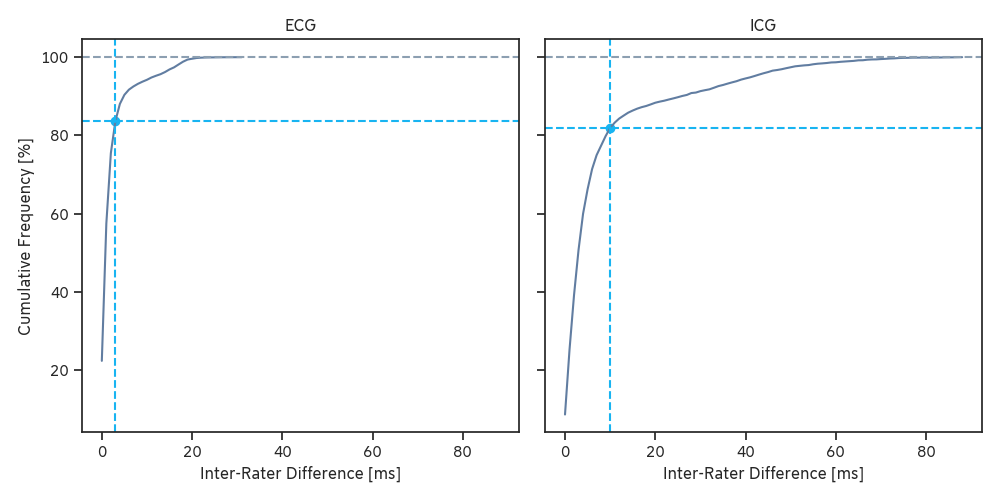

In [20]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

labels_ecg_diff_cum = labels_ecg_diff.abs().value_counts().sort_index().cumsum()
labels_ecg_diff_cum = labels_ecg_diff_cum / labels_ecg_diff_cum.iloc[-1] * 100
labels_ecg_diff_cum = labels_ecg_diff_cum.to_frame("count")
labels_ecg_diff_cum.index = pd.Index([i[0] for i in labels_ecg_diff_cum.index], name="Inter-Rater Difference [ms]")
labels_ecg_diff_cum.index = labels_ecg_diff_cum.index / dataset_empkins_01.sampling_rate_ecg * 1000

labels_icg_diff_cum = labels_icg_diff.abs().value_counts().sort_index().cumsum()
labels_icg_diff_cum = labels_icg_diff_cum / labels_icg_diff_cum.iloc[-1] * 100
labels_icg_diff_cum = labels_icg_diff_cum.to_frame("count")
labels_icg_diff_cum.index = pd.Index([i[0] for i in labels_icg_diff_cum.index], name="Inter-Rater Difference [ms]")
labels_icg_diff_cum.index = labels_icg_diff_cum.index / dataset_empkins_01.sampling_rate_icg * 1000

cutoff_ecg = int(0.8 * labels_ecg_diff_cum.iloc[-1].iloc[0])
cutoff_ecg = labels_ecg_diff_cum[(labels_ecg_diff_cum <= cutoff_ecg).diff()].dropna().iloc[-1].name

cutoff_icg = int(0.8 * labels_icg_diff_cum.iloc[-1].iloc[0])
cutoff_icg = labels_icg_diff_cum[(labels_icg_diff_cum <= cutoff_icg).diff()].dropna().iloc[-1].name

print(cutoff_ecg, cutoff_icg)

labels_ecg_diff_cum.plot(ax=axs[0])
labels_icg_diff_cum.plot(ax=axs[1])

axs[0].axhline(100, color=cmaps.tech[0], ls="--")
axs[0].axvline(cutoff_ecg, color=cmaps.med[0], ls="--")
axs[0].axhline(labels_ecg_diff_cum.loc[cutoff_ecg].iloc[0], color=cmaps.med[0], ls="--")
axs[0].scatter(cutoff_ecg, labels_ecg_diff_cum.loc[cutoff_ecg].iloc[0], color=cmaps.med[0])

axs[1].axhline(100, color=cmaps.tech[0], ls="--")
axs[1].axvline(cutoff_icg, color=cmaps.med[0], ls="--")
axs[1].axhline(labels_icg_diff_cum.loc[cutoff_icg].iloc[0], color=cmaps.med[0], ls="--")
axs[1].scatter(cutoff_icg, labels_icg_diff_cum.loc[cutoff_icg].iloc[0], color=cmaps.med[0])

axs[0].set_title("ECG")
axs[1].set_title("ICG")

axs[0].set_ylabel("Cumulative Frequency [%]")
axs[1].set_ylabel("Cumulative Frequency [%]")

axs[0].legend().remove()
axs[1].legend().remove()

fig.tight_layout()

## Export

In [37]:
bp.io.write_pandas_dict_excel(dict_results, export_path.joinpath("result_summary_rater_agreement_empkins.xlsx"))